In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import datetime as dt
from datetime import datetime, timedelta
import calendar

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows

from Position_Report_Calcs import Position_Reporting

In [2]:
plotly.offline.init_notebook_mode(connected=True)

In [3]:
def reporting_date(run_date='today'):
    if run_date=='today':
        current_date = dt.datetime.today().date()
        current_year = current_date.year
    else:
        current_date = run_date
        current_year = current_date.year
    return current_date, current_year
        
#current_date, current_year = reporting_date(run_date = dt.datetime.strptime('21-06-2024', '%d-%m-%Y').date())    # for a specific date
current_date, current_year = reporting_date()    # as at today

In [4]:
def get_month_year(months_fwd):   # This is incase the months fwd overlaps into a different year
    current_date = dt.datetime.today().date()
    month = current_date.month + months_fwd
    year = current_date.year
    if month > 12:
        month -=12
        year += 1
        
    _, last_day_of_month = calendar.monthrange(year, month)
    date_to_use = dt.date(year, month, last_day_of_month)
    return date_to_use

In [61]:
## Define the dates we want to use for reporting
#current_date = dt.datetime.today().date()
#current_year = str(dt.datetime.today().date().year)

_, last_day = calendar.monthrange(current_date.year, current_date.month)
end_of_month = dt.date(current_date.year, current_date.month, last_day)
two_months = get_month_year(2)
three_months = get_month_year(3)
four_months = get_month_year(4)
five_months = get_month_year(5)
six_months = get_month_year(6)

dec_exp = dt.datetime.strptime('16-12-2025', '%d-%m-%Y').date()

## MORE GRANULAR ##
# Get the current date
today = datetime.now()
# Calculate the number of days until the next Saturday (because we want the full friday session)
days_until_saturday = (5 - today.weekday()) % 7  # Saturday is weekday 5
# Get the date of the end of the current week (this coming Saturday)
end_of_this_week_saturday = today + timedelta(days=days_until_saturday)
# Get the end of next week by adding 7 more days
end_this_wk = end_of_this_week_saturday.date()
end_next_wk= end_of_this_week_saturday + timedelta(weeks=1)
end_next_wk = end_next_wk.date()
end_two_wk = end_of_this_week_saturday + timedelta(weeks=2)
end_two_wk = end_two_wk.date()

four_weeks = end_of_this_week_saturday + timedelta(weeks=4)
four_weeks = four_weeks.date()
six_weeks = end_of_this_week_saturday + timedelta(weeks=6)
six_weeks = six_weeks.date()

dates_names = ['today','End of This Wk','End of Next Wk','End of 2 Wks','EoM','4 Weeks','6 Weeks','2 Months','3 Months','4 Months', '5 Months', '6 Months', 'Dec Expiry']
dates_values = [current_date, end_this_wk, end_next_wk, end_two_wk, end_of_month, four_weeks, six_weeks, two_months, three_months, four_months, five_months, six_months, dec_exp]

In [63]:
## Read in the position data
mkts = ['ACCU','NZU','RGGI']

positions = dict()
for m in mkts:
    positions[m] = pd.read_excel('Positions.xlsx', sheet_name=m)
    positions[m]['Expiry'] = pd.to_datetime(positions[m].Expiry).dt.date
    positions[m] = positions[m][~((positions[m]['Type'] == 'Option') & (positions[m]['Expiry'] < current_date))] # remove expired options

premiums = pd.read_excel('Positions.xlsx', sheet_name='Index') 

In [64]:
beta = pd.read_excel('Positions.xlsx', sheet_name='Allocation')
beta

,Market,1% Move (Adj for FUM FX),AUD Required Return,Required Delta,Current Delta,Actual Weight (% FUM),Over / Under Weight
0,EUA,0.000,7422.112408,NaN,-32.000000,0.000000,-0.166667
1,UKA,0.000,6449.636402,NaN,17.000000,0.000000,-0.166667
2,ACCU,0.355,13333.333333,39215.686275,32.255000,0.137084,-0.029583
3,LGC,NaN,NaN,NaN,NaN,NaN,NaN
4,NZU,0.000,14584.700649,25146.035602,123.609356,0.000000,-0.166667
5,CCA,0.000,8711.333333,NaN,NaN,NaN,NaN


In [67]:
dates = dict()
for i in list(range(0,len(dates_names))):
    dates[dates_names[i]] = dates_values[i]

In [69]:
current_spot = positions['RGGI']
current_spot = current_spot[current_spot.Type=='Spot'].reset_index(drop=True)
current_spot = current_spot['Price'][0]

# RGGI Position Report
All PnL figures are in AUD

In [72]:
z = current_date.strftime('%d-%m-%Y')
print('Report as at {}'.format(z))

Report as at 26-09-2024


In [74]:
RGGIs = dict()
workbook = openpyxl.Workbook()

for i,d in enumerate(dates_values):
    RGGIs[d] = Position_Reporting(positions, 'RGGI', d).combine_frame()
    
    # Generate an excel file
    sheet_name = dates_names[i]
    sheet = workbook.create_sheet(title=sheet_name)    
    for row in dataframe_to_rows(RGGIs[d][0], index=False, header=True):
        sheet.append(row)
    
workbook.save('RGGI PnL Output.xlsx')

beta_pnl = Position_Reporting(positions, 'RGGI', d).beta_pnl()


In [75]:
# data type; 0=PnL, 1=Delta, 2=Option Theta, 3=Option Vega
def generate_summary_plots(mkt_data, data_type):
    if data_type==0:
        colname='Total_Pnl'
    elif data_type==1:
        colname='Total_Delta'
    elif data_type==2:
        colname='Option_Theta'
    elif data_type==3:
        colname='Option_Vega'
    fig = go.Figure()
    for i in list(range(0, len(dates_names))):
        date_value = dates_values[i]
        date_name = dates_names[i]
        fig.add_trace(go.Scatter(x=mkt_data[date_value][data_type].Price, y=mkt_data[date_value][data_type][colname], name=date_name))
    return fig

In [76]:
beta_pnl = Position_Reporting(positions,'RGGI',d).beta_pnl()

beta_delta = Position_Reporting(positions,'RGGI',d).beta_units()
beta_delta = beta_delta['RGGI']
delta_frame = pd.DataFrame()
delta_frame['Price'] = beta_pnl.Price
delta_frame['Beta'] = beta_delta

In [77]:
fig_d = generate_summary_plots(RGGIs, 1)
fig_d = fig_d.add_trace(go.Scatter(x=delta_frame['Price'], y=delta_frame['Beta'], name='Beta'))

fig_p = generate_summary_plots(RGGIs, 0)
fig_p = fig_p.add_trace(go.Scatter(x=beta_pnl['Price'], y=beta_pnl['Spot'], name='Beta'))

fig_t = generate_summary_plots(RGGIs,2)
fig_v = generate_summary_plots(RGGIs,3)

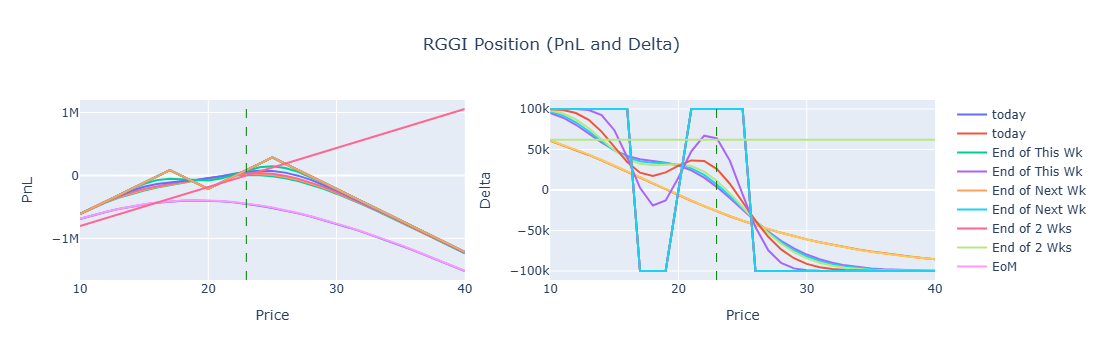

In [78]:
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_d.data)):
    fig.add_trace(fig_p.data[i], row=1, col=1)
    fig.add_trace(fig_d.data[i], row=1, col=2)

fig.update_layout(title={'text': 'RGGI Position (PnL and Delta)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="PnL", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)

fig.add_vline(x=current_spot, line_width=1, line_dash="dash", line_color="green")

fig.show()

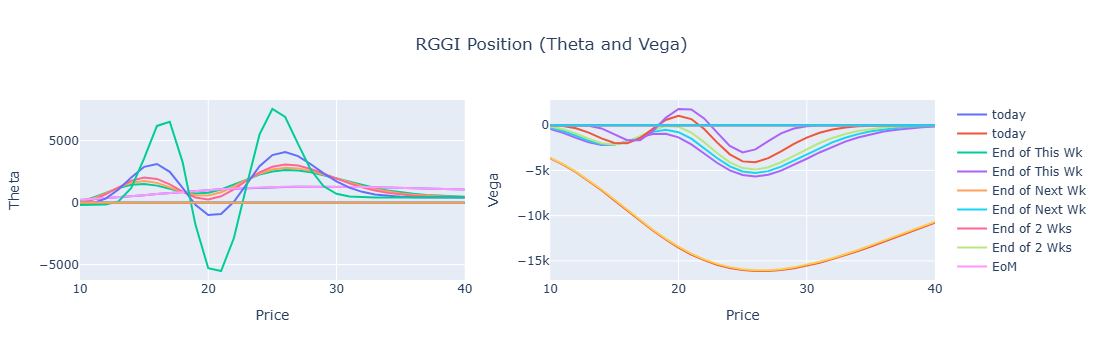

In [83]:
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_t.data)):
    fig.add_trace(fig_t.data[i], row=1, col=1)
    fig.add_trace(fig_v.data[i], row=1, col=2)

fig.update_layout(title={'text': 'RGGI Position (Theta and Vega)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Theta", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Vega", row=1, col=2)
fig.show()

# Today's Position

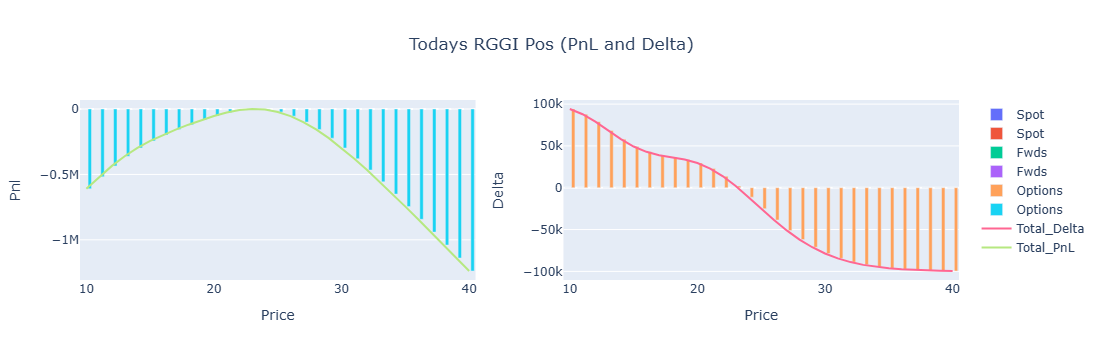

In [19]:
## USE THIS STYLE OF GRAPHING FOR TODAY DATE ENTRY ##
position_functions = Position_Reporting(positions, 'RGGI', current_date)
pnl, delta, theta, vega, value = position_functions.combine_frame()

fig_d = go.Figure()

fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Spot, name='Spot', base=0))
fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Fwds, name='Fwds', base=0))
fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Options, name='Options', base=0))
fig_d.add_trace(go.Scatter(x=delta.Price, y=delta.Total_Delta, mode='lines', name='Total_Delta'))

#fig_d.update_layout(title='ACCU Delta Today', xaxis_title='Price', yaxis_title='Delta', barmode='stack')
#fig_d.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_p = go.Figure()

fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Spot, name='Spot', base=0))
fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Fwds, name='Fwds', base=0))
fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Options, name='Options', base=0))
fig_p.add_trace(go.Scatter(x=pnl.Price, y=pnl.Total_Pnl, mode='lines', name='Total_PnL'))

#fig_p.update_layout(title='ACCU PnL Today', xaxis_title='Price', yaxis_title='pnl', barmode='stack')
#fig_p.show()


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_d.data)):
    fig.add_trace(fig_d.data[i], row=1, col=2)
    fig.add_trace(fig_p.data[i], row=1, col=1)
    
#fig.update_layout(title={'text': 'Todays RGGI Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'}, barmode='stack')
fig.update_layout(title={'text': 'Todays RGGI Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Pnl", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)    
fig.show()  

  # Options Book

In [21]:
p,d,t,v, value = position_functions.options()

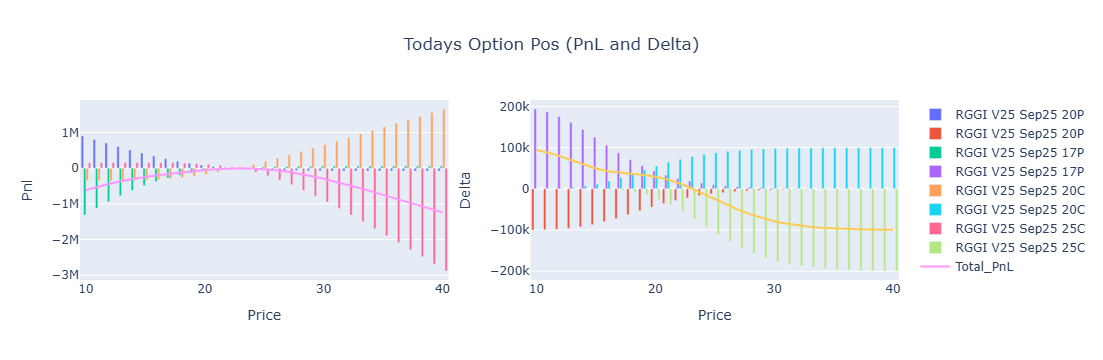

In [22]:
fig_p = go.Figure()
for i in list(p)[1:-1]:
    fig_p.add_trace(go.Bar(x=p.Price, y=p[i], name=i, base=0))

fig_p.add_trace(go.Scatter(x=p.Price, y=p.Option_Pnl, mode='lines', name='Total_PnL'))

#fig_p.update_layout(title='Option PnL Today', xaxis_title='Price', yaxis_title='pnl', barmode='stack')
#fig_p.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_d = go.Figure()
for i in list(d)[1:-1]:
    fig_d.add_trace(go.Bar(x=d.Price, y=d[i], name=i, base=0))

fig_d.add_trace(go.Scatter(x=d.Price, y=d.Option_Delta, mode='lines', name='Total_Delta'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_p.data)):
    fig.add_trace(fig_p.data[i], row=1, col=1)
    fig.add_trace(fig_d.data[i], row=1, col=2)
    
#fig.update_layout(title={'text': 'Todays Option Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'}, barmode='stack')
fig.update_layout(title={'text': 'Todays Option Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Pnl", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)    
fig.show()  

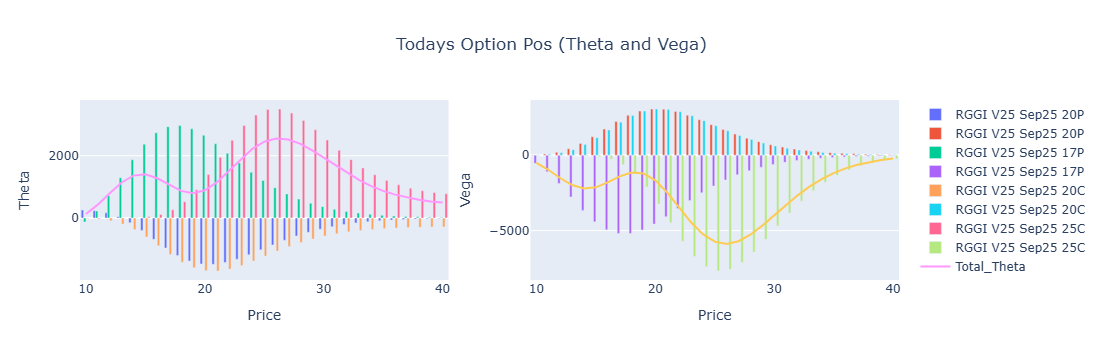

In [23]:
fig_t = go.Figure()
for i in list(t)[1:-1]:
    fig_t.add_trace(go.Bar(x=t.Price, y=t[i], name=i, base=0))

fig_t.add_trace(go.Scatter(x=t.Price, y=t.Option_Theta, mode='lines', name='Total_Theta'))


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_v = go.Figure()
for i in list(v)[1:-1]:
    fig_v.add_trace(go.Bar(x=v.Price, y=v[i], name=i, base=0))

fig_v.add_trace(go.Scatter(x=v.Price, y=v.Option_Vega, mode='lines', name='Total_Vega'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_p.data)):
    fig.add_trace(fig_t.data[i], row=1, col=1)
    fig.add_trace(fig_v.data[i], row=1, col=2)
    
#fig.update_layout(title={'text': 'Todays Option Pos (Theta and Vega)','x': 0.5,'xanchor': 'center'}, barmode='stack')
fig.update_layout(title={'text': 'Todays Option Pos (Theta and Vega)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Theta", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Vega", row=1, col=2)    
fig.show()  

# Option PnL & Delta At Different Points in Time
Need to rebase the option values to date of calc  
Delta will be correct  
Incrimental PnL will be correct, just rebase to zero

# Ignore For Now, Needs Adjusting
Recalculate the starting option value so that forward looking pnl / theta it is not relative to todays value

In [26]:
## Define the dates we want to use for reporting
current_date = dt.datetime.today().date()
current_year = str(dt.datetime.today().date().year)

_, last_day = calendar.monthrange(current_date.year, current_date.month)
end_of_month = dt.date(current_date.year, current_date.month, last_day)

one_month = current_date + dt.timedelta(days=1*30)

three_months = current_date + dt.timedelta(days=3*30)

six_months = current_date + dt.timedelta(days=6*30)

eoy = '10-12-{}'.format(current_year)
end_of_year = dt.datetime.strptime(eoy, '%d-%m-%Y').date()

one_year = current_date + dt.timedelta(days=365)

post_june = dt.datetime.strptime('20-06-2024', '%d-%m-%Y').date()
post_sep = dt.datetime.strptime('26-09-2024', '%d-%m-%Y').date()

In [27]:
# Options for timing are: [current_date, end_of_month, one_month, three_months, six_months, end_of_year, end_of_feb, march_expiry]

def pnl_delta_plot(timing):
    position_functions = Position_Reporting(positions, 'RGGI', timing)
    p,d,t,v, value = position_functions.options()
    fig_p = go.Figure()
    for i in list(p)[1:-1]:
        fig_p.add_trace(go.Scatter(x=p.Price, y=p[i], name=i))

    fig_p.add_trace(go.Scatter(x=p.Price, y=p.Option_Pnl, mode='lines', name='Total_PnL'))

    #fig_p.update_layout(title='Option PnL Today', xaxis_title='Price', yaxis_title='pnl', barmode='stack')
    #fig_p.show()

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    fig_d = go.Figure()
    for i in list(d)[1:-1]:
        fig_d.add_trace(go.Scatter(x=d.Price, y=d[i], name=i))

    fig_d.add_trace(go.Scatter(x=d.Price, y=d.Option_Delta, mode='lines', name='Total_Delta'))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    fig = make_subplots(rows=1, cols=2)
    for i in range(0,len(fig_p.data)):
        fig.add_trace(fig_p.data[i], row=1, col=1)
        fig.add_trace(fig_d.data[i], row=1, col=2)

    fig.update_layout(title={'text': 'Todays Option Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'}, barmode='stack')

    fig.update_xaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Pnl", row=1, col=1)
    fig.update_xaxes(title_text="Price", row=1, col=2)
    fig.update_yaxes(title_text="Delta", row=1, col=2)    
    
    fig.add_vline(x=current_spot, line_width=1, line_dash="dash", line_color="green")
    fig.show()  

## Post Sep Expiry

In [29]:
current_date = post_sep
positions = dict()
for m in mkts:
    positions[m] = pd.read_excel('Positions.xlsx', sheet_name=m)
    positions[m]['Expiry'] = pd.to_datetime(positions[m].Expiry).dt.date
    positions[m] = positions[m][~((positions[m]['Type'] == 'Option') & (positions[m]['Expiry'] < current_date))] # remove expired options

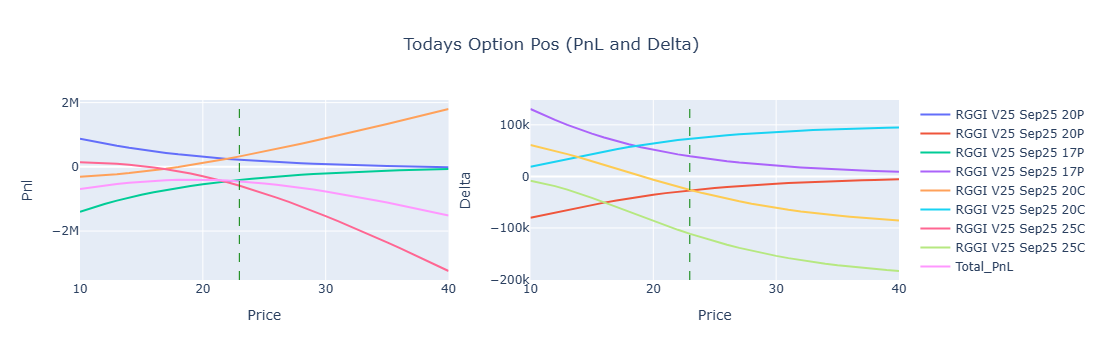

In [30]:
pnl_delta_plot(post_sep)

Post Sep Expiry, End of Year (to see theta impact)

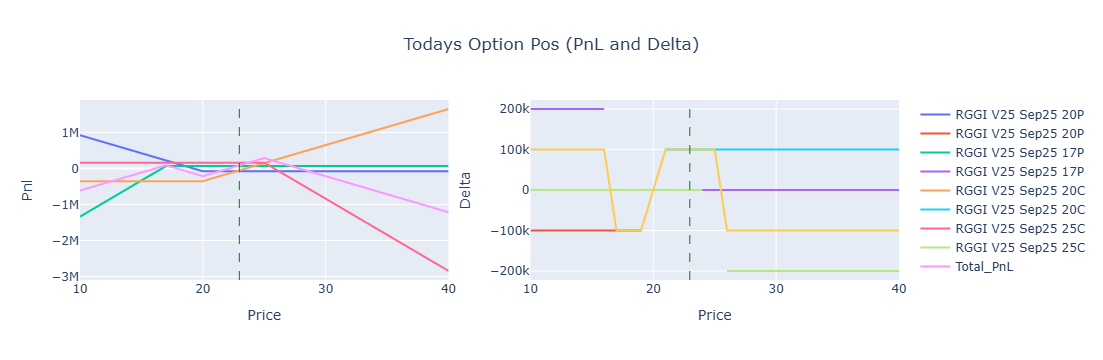

In [32]:
pnl_delta_plot(end_of_year)

# Historical Volatility

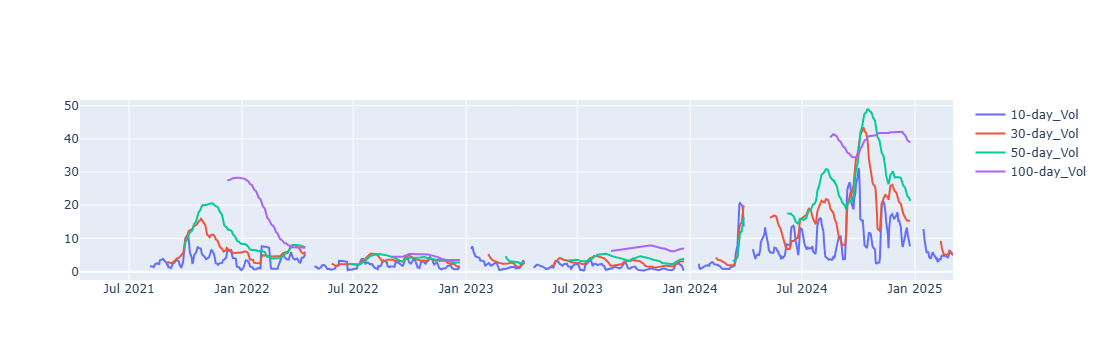

In [34]:
histvol = Position_Reporting(positions, 'RGGI', current_date).rolling_vol()

fig = go.Figure()
for i in list(histvol)[1:]:
    fig.add_trace(go.Scatter(x=histvol['Date'], y=histvol[i], name=i))#, base=0))
    
fig.show()